In [1]:
from pathlib import Path
import glob
import exiftool
import suncalc
import soundfile as sf
import re

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [4]:
SEATTLE_LATITUDE = 47.655181
SEATTLE_LONGITUDE = -122.293123

In [6]:
def clean_up_observations_and_add_sum_column(atg_obs, col):
    no_erros_obs = atg_obs.loc[(atg_obs[col]!='M')&(atg_obs[col]!='MM')].copy()

    no_erros_obs['datetime_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC'])
    no_erros_obs['Date_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).date
    no_erros_obs['Time_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).time
    no_erros_obs[col] = no_erros_obs[col].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_UTC'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_UTC'].first()
    atg_obs_necessary[col.lower()] = first_obs_each_period[col].sum()

    atg_obs_necessary = atg_obs_necessary.dropna()
    atg_obs_necessary.index = pd.DatetimeIndex(atg_obs_necessary.index)

    return atg_obs_necessary


def clean_up_observations_and_add_column(atg_obs, col):
    no_erros_obs = atg_obs.loc[(atg_obs[col]!='M')&(atg_obs[col]!='MM')].copy()

    no_erros_obs['datetime_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC'])
    no_erros_obs['Date_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).date
    no_erros_obs['Time_UTC'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).time
    no_erros_obs[col] = no_erros_obs[col].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_UTC'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_UTC'].first()
    atg_obs_necessary[col.lower()] = first_obs_each_period[col].mean()

    atg_obs_necessary = atg_obs_necessary.dropna()
    atg_obs_necessary.index = pd.DatetimeIndex(atg_obs_necessary.index)

    return atg_obs_necessary

In [13]:
def plot_cumulative_var(activity_df, data_params, plot_title, col, save=True):
    
    masked_array_for_nodets = np.ma.masked_where(activity_df.values==0, activity_df.values)

    activity_times = pd.to_datetime(activity_df.index, format='%H:%M:%S').tz_localize('UTC')
    ylabel = 'UTC'
    if data_params["show_PST"]:
        activity_times = activity_times.tz_convert(tz='US/Pacific')
        ylabel = 'PST'
    activity_times = activity_times.strftime("%H:%M")

    cmap = plt.get_cmap('jet')
    cmap.set_bad(color='white')
    plot_dates = [''] * len(activity_df.columns)
    plot_dates[::7] = activity_df.columns[::7]
    plot_times = [''] * len(activity_times)
    plot_times[::3] = activity_times[::3]

    activity_dates = pd.to_datetime(activity_df.columns.values, format='%m/%d/%y')
    activity_lat = [SEATTLE_LATITUDE]*len(activity_dates)
    activity_lon = [SEATTLE_LONGITUDE]*len(activity_dates)
    sunrise_time = pd.DatetimeIndex(suncalc.get_times(activity_dates, activity_lon, activity_lat)['sunrise_end'])
    sunset_time = pd.DatetimeIndex(suncalc.get_times(activity_dates, activity_lon, activity_lat)['sunset_start'])
    sunrise_seconds_from_midnight = sunrise_time.hour * 3600 + sunrise_time.minute*60 + sunrise_time.second
    sunset_seconds_from_midnight = sunset_time.hour * 3600 + sunset_time.minute*60 + sunset_time.second

    recent_sunrise = sunrise_time.tz_convert(tz="US/Pacific").strftime("%H:%M")[-1]
    recent_sunset = sunset_time.tz_convert(tz="US/Pacific").strftime("%H:%M")[-1]

    plt.rcParams.update({'font.size': 2*len(plot_dates)**0.5})
    plt.figure(figsize=(len(plot_dates)/4, len(plot_times)/4))
    plt.title(plot_title, loc='center', y=1.05, fontsize=(3)*len(plot_dates)**0.5)
    plt.plot(np.arange(0, len(plot_dates)), ((sunset_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
            color='k', linewidth=5, linestyle='dashed', label=f'Time of Sunset (Recent: {recent_sunset} PST)')
    plt.axhline(y=14-0.5, linewidth=5, linestyle='dashed', color='k', label='Midnight 0:00 PST')
    plt.plot(np.arange(0, len(plot_dates)), ((sunrise_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
            color='k', linewidth=5, linestyle='dashed', label=f'Time of Sunrise (Recent: {recent_sunrise} PST)')
    if col =='Rain':
        plt.imshow(masked_array_for_nodets, cmap=cmap, norm=colors.LogNorm(vmin=1e2, vmax=1e5))
    else:
        plt.imshow(masked_array_for_nodets, cmap=cmap)
    plt.yticks(np.arange(0, len(plot_times))-0.5, plot_times, rotation=30)
    plt.xticks(np.arange(0, len(plot_dates))-0.5, plot_dates, rotation=30)
    plt.ylabel(f'{ylabel} Time (HH:MM)')
    plt.xlabel('Date (MM/DD/YY)')
    plt.colorbar()
    plt.legend(loc=3, fontsize=(2*len(plot_dates)**0.5))
    plt.grid(which='both')
    plt.tight_layout()
    plt.show()

In [16]:
year=2024
date_start = dt.datetime(year,3,29,0,0,0)
date_end = dt.datetime(year,8,12,0,0,0)

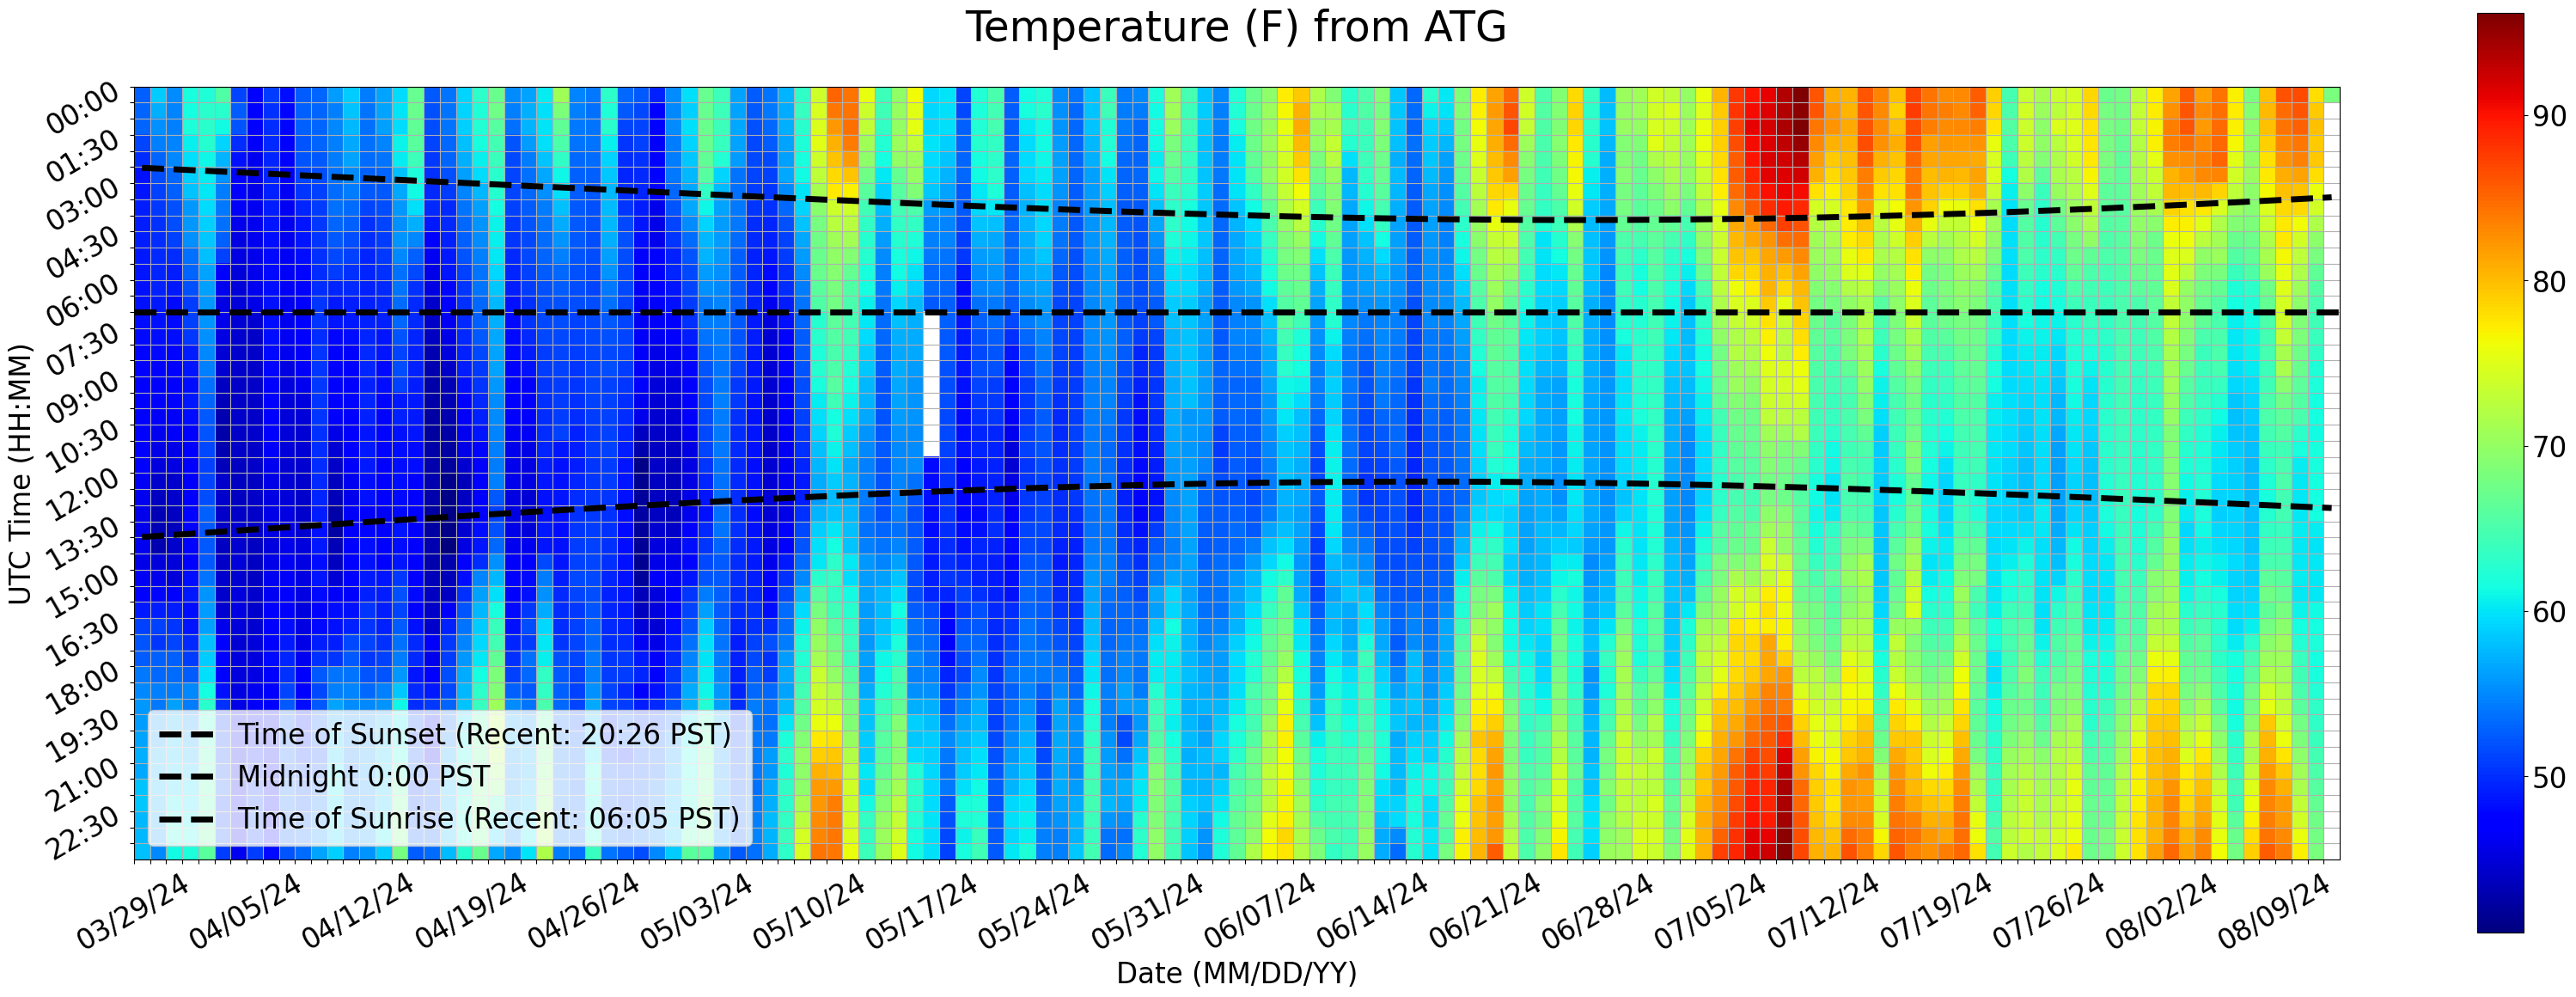

In [18]:
# for site in ['ATG', 'CUH', 'RAWS']:
data_params=dict()
data_params["site"] = "ATG"
data_params['show_PST'] = False

atg_obs=pd.read_csv(f'../../Downloads/LFEM_data-{data_params["site"]}.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=date_start)&(atg_obs['datetime_UTC']<=date_end)]
col = 'Temperature'
relevant = clean_up_observations_and_add_column(atg_obs_selected, col)
vars = relevant[col.lower()]
fixed_vars = vars.reindex(pd.date_range(date_start, date_end, freq='30min'), fill_value=np.NaN)

raw_dates = fixed_vars.index.date
raw_times = fixed_vars.index.time
data = list(zip(raw_dates, raw_times, fixed_vars.values))
var_data = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col.lower()])
var_df = var_data.pivot(index="Time (UTC)", columns="Date (UTC)", values=col.lower())
var_df.columns = pd.to_datetime(var_df.columns).strftime('%m/%d/%y')

plot_cumulative_var(var_df, data_params, f"{col} (F) from {data_params['site']}", col, save=False)

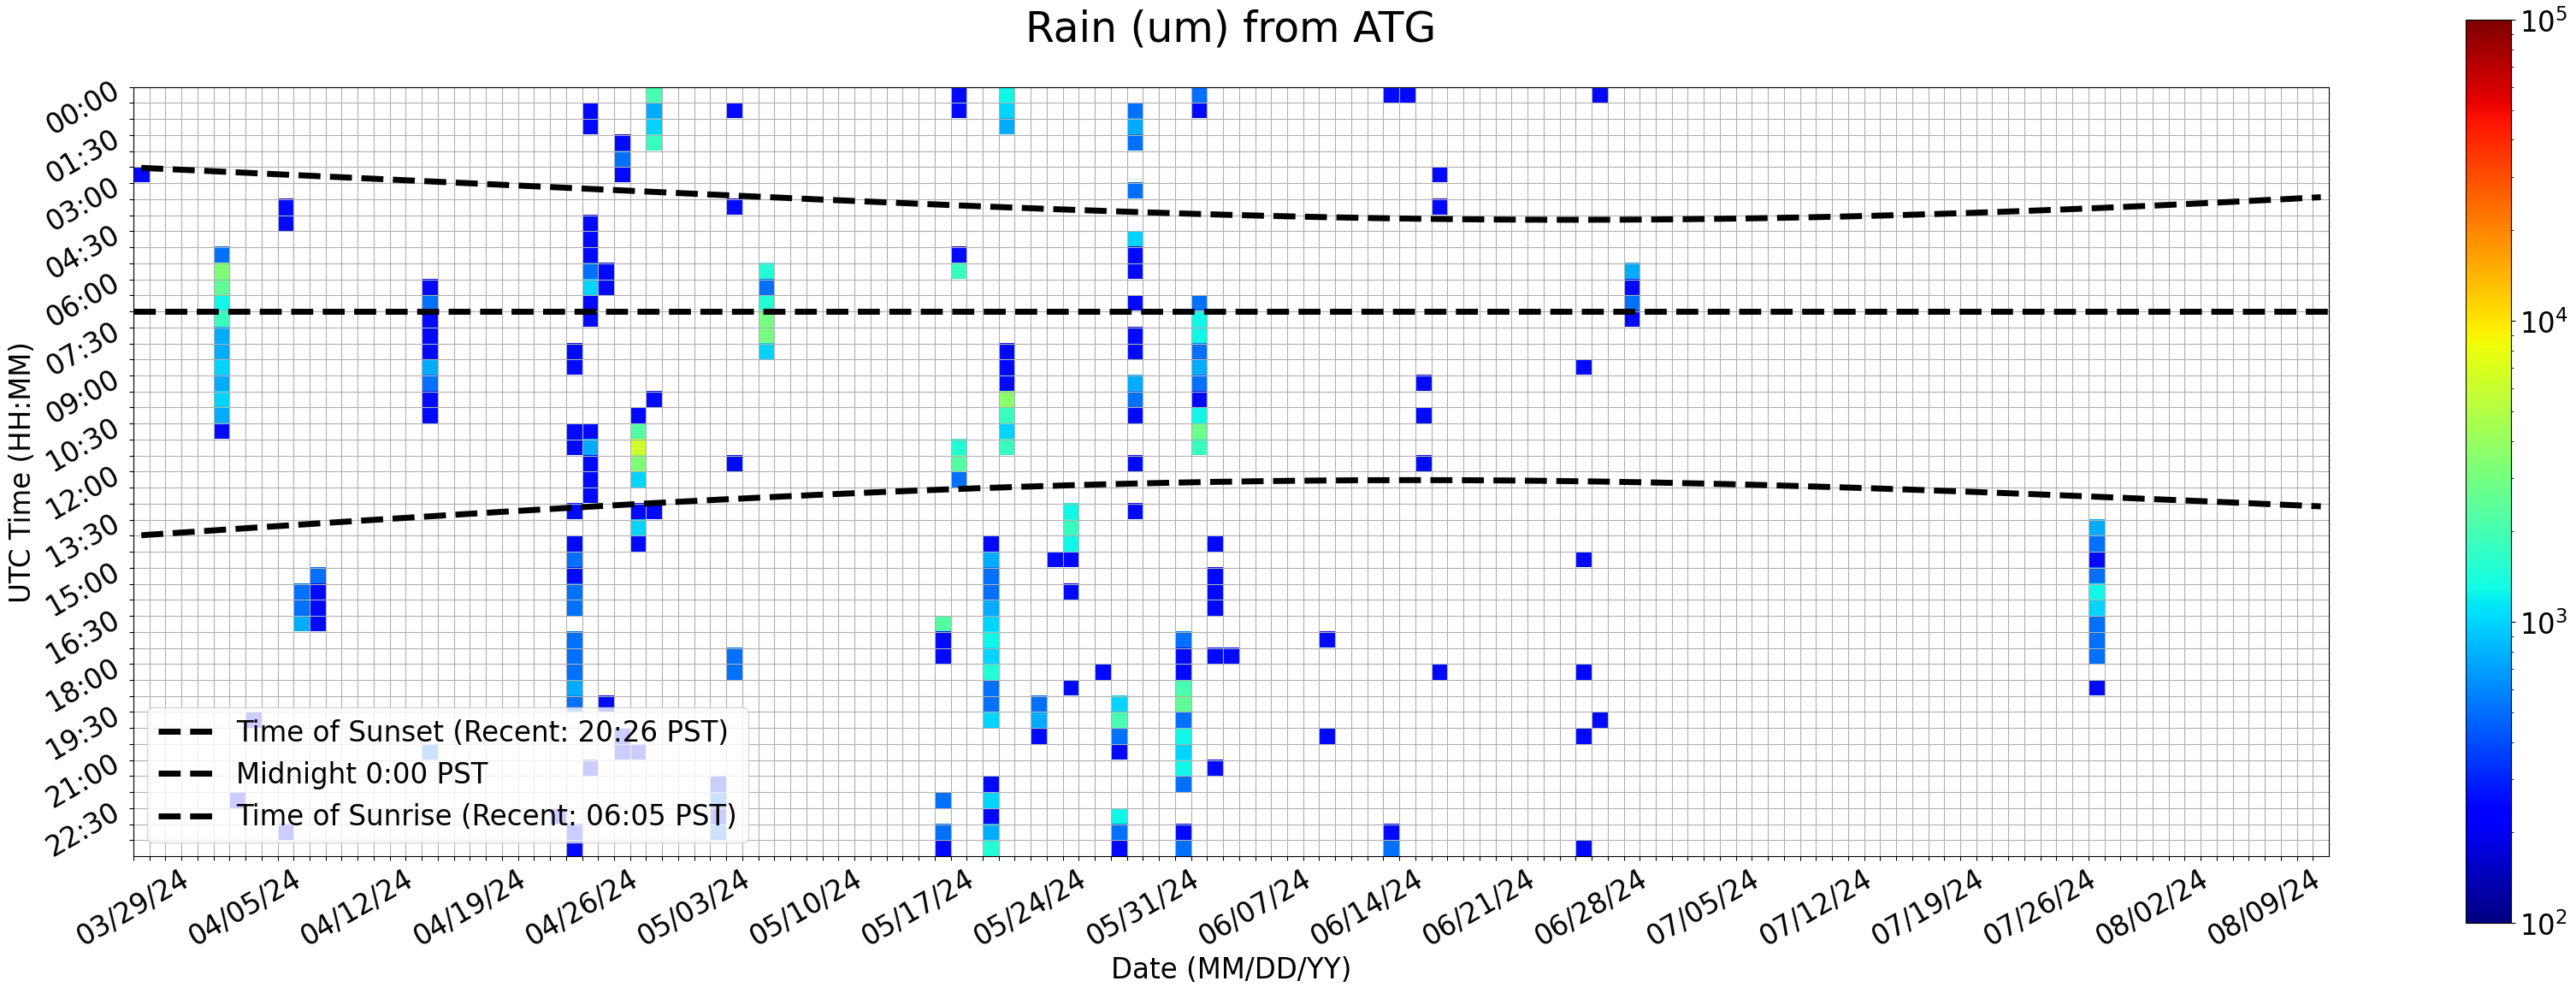

In [17]:
# for site in ['ATG', 'CUH', 'RAWS']:
data_params=dict()
data_params["site"] = "ATG"
data_params['show_PST'] = False

atg_obs=pd.read_csv(f'../../Downloads/LFEM_data-{data_params["site"]}.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))
# for year in range(2020, 2025):
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=date_start)&(atg_obs['datetime_UTC']<=date_end)]
col = 'Rain'
relevant = clean_up_observations_and_add_sum_column(atg_obs_selected, col)
vars = relevant[col.lower()]
fixed_vars = vars.reindex(pd.date_range(date_start, date_end, freq='30min'), fill_value=np.NaN)

raw_dates = fixed_vars.index.date
raw_times = fixed_vars.index.time
data = list(zip(raw_dates, raw_times, fixed_vars.values))
var_data = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col.lower()])
var_df = var_data.pivot(index="Time (UTC)", columns="Date (UTC)", values=col.lower())
var_df.columns = pd.to_datetime(var_df.columns).strftime('%m/%d/%y')

plot_cumulative_var(var_df*25400, data_params, f"{col} (um) from {data_params['site']}", col, save=False)

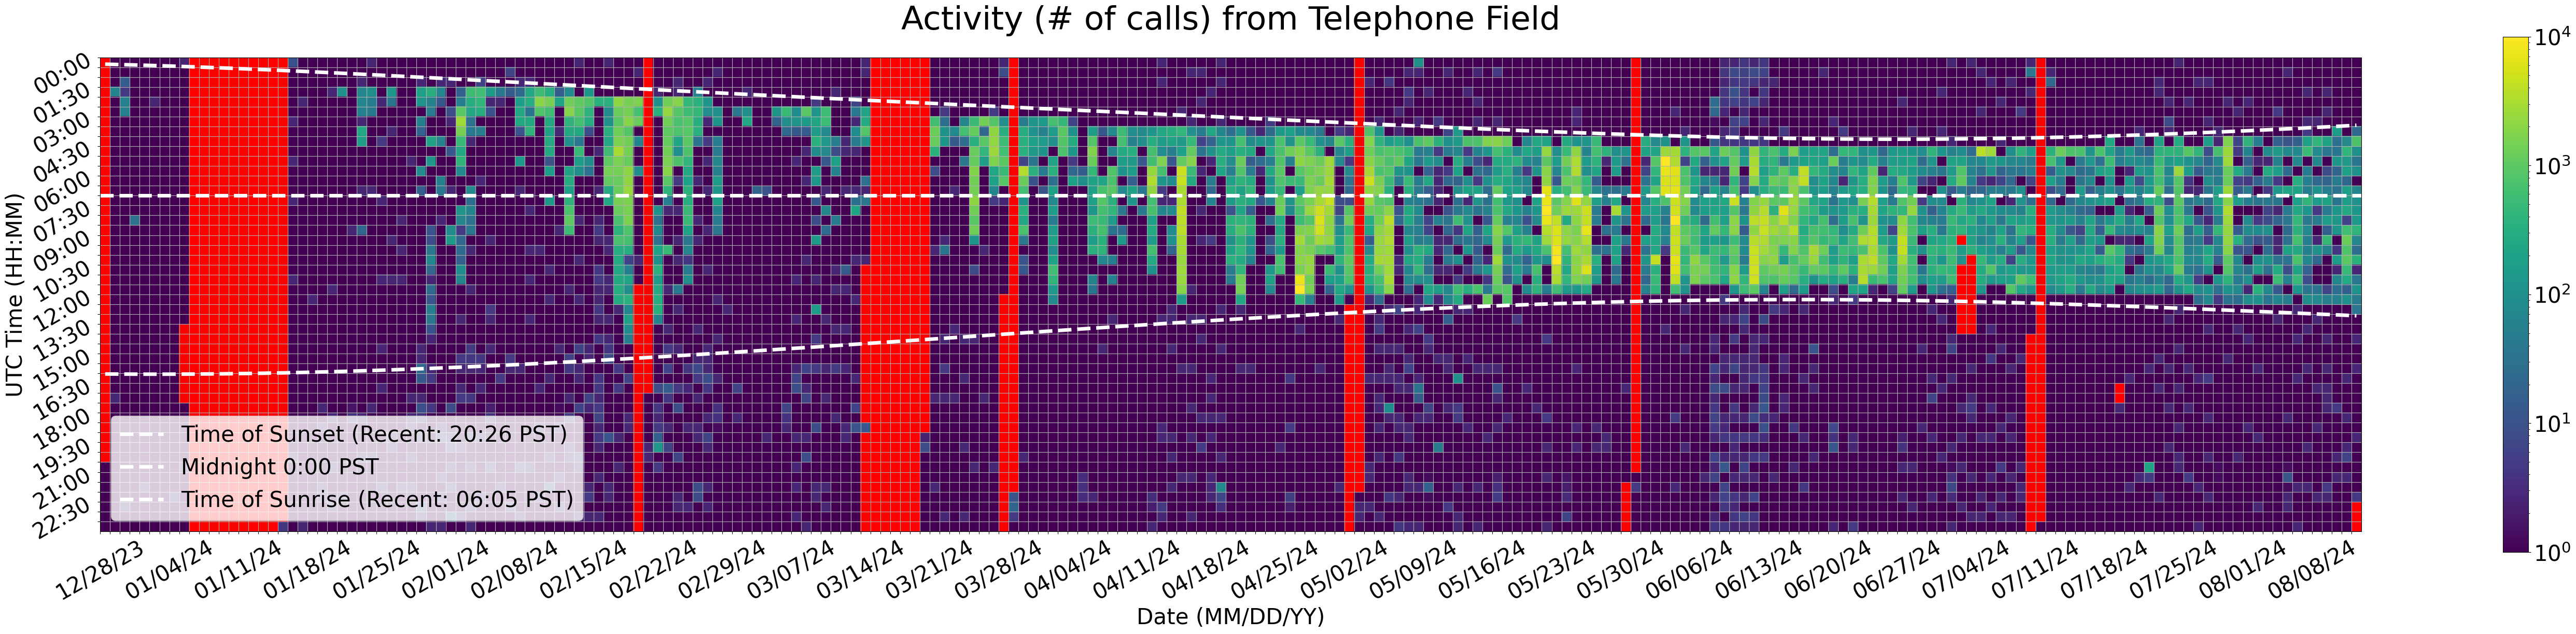

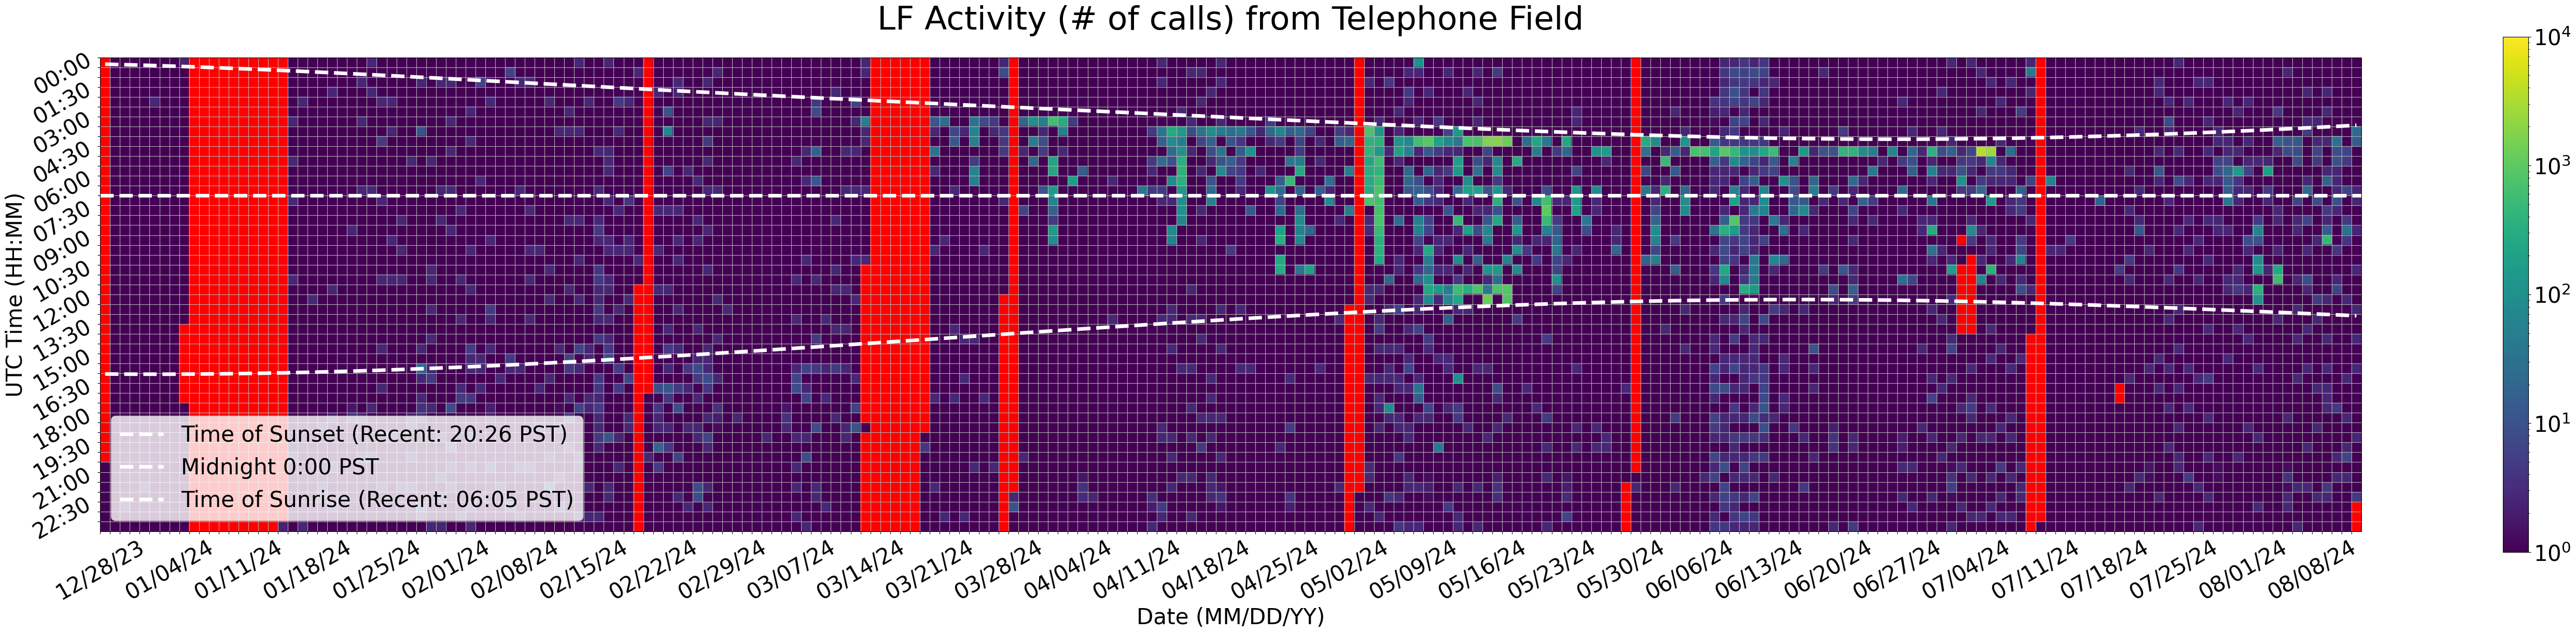

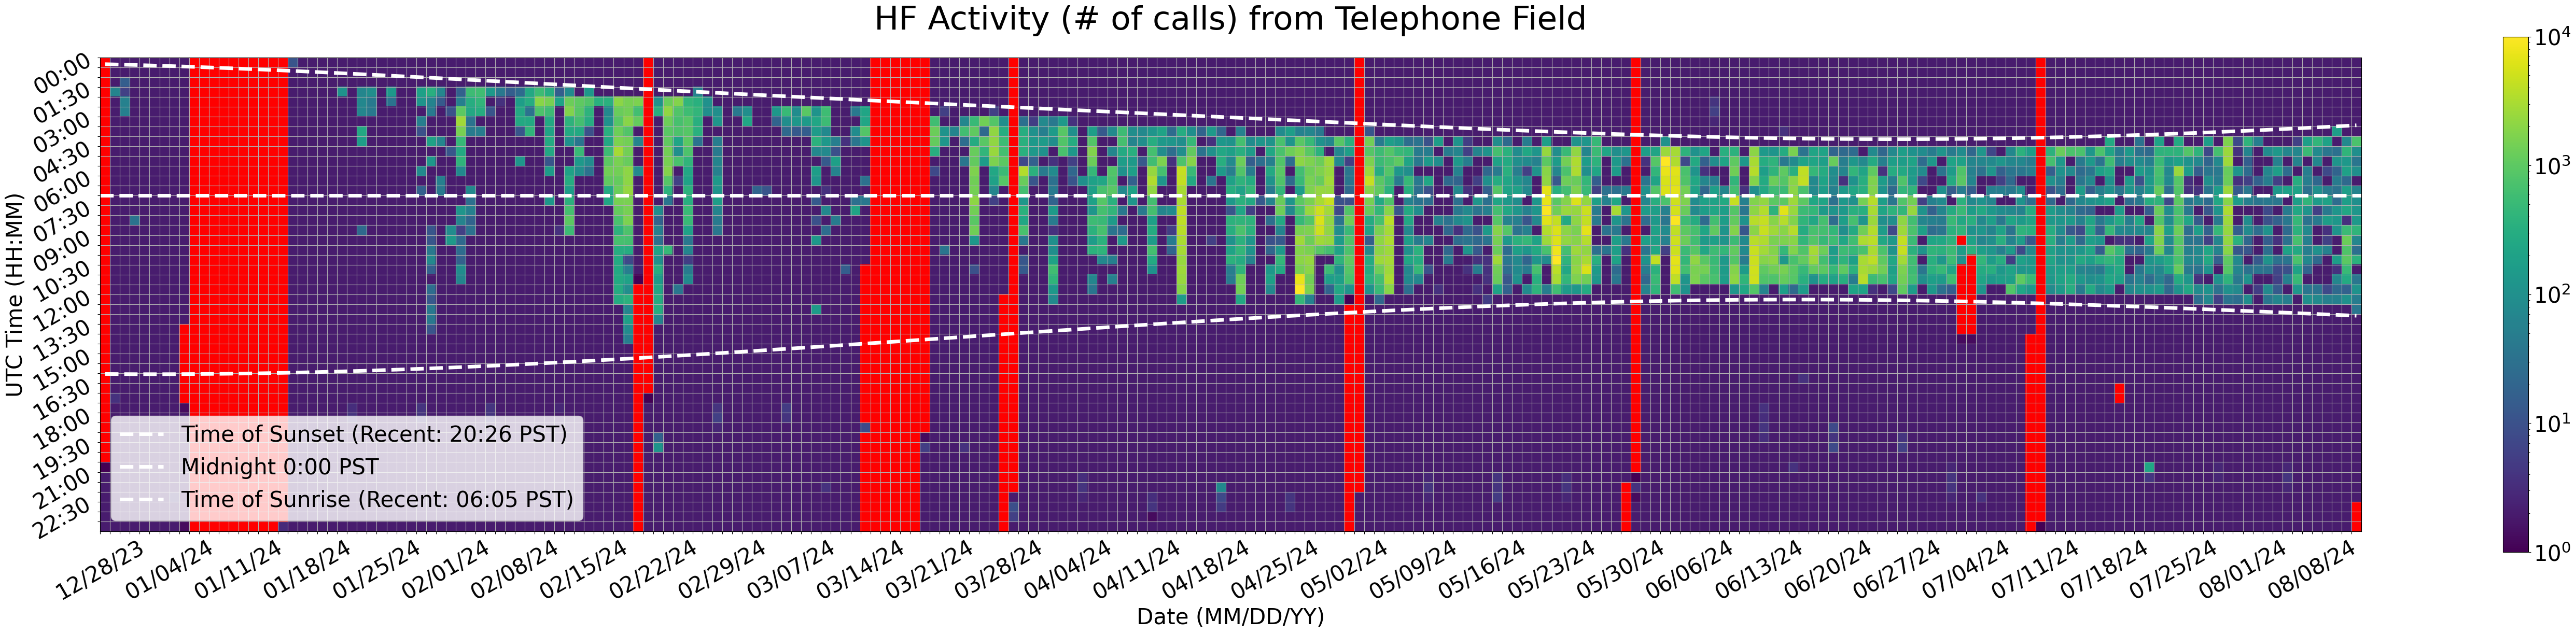

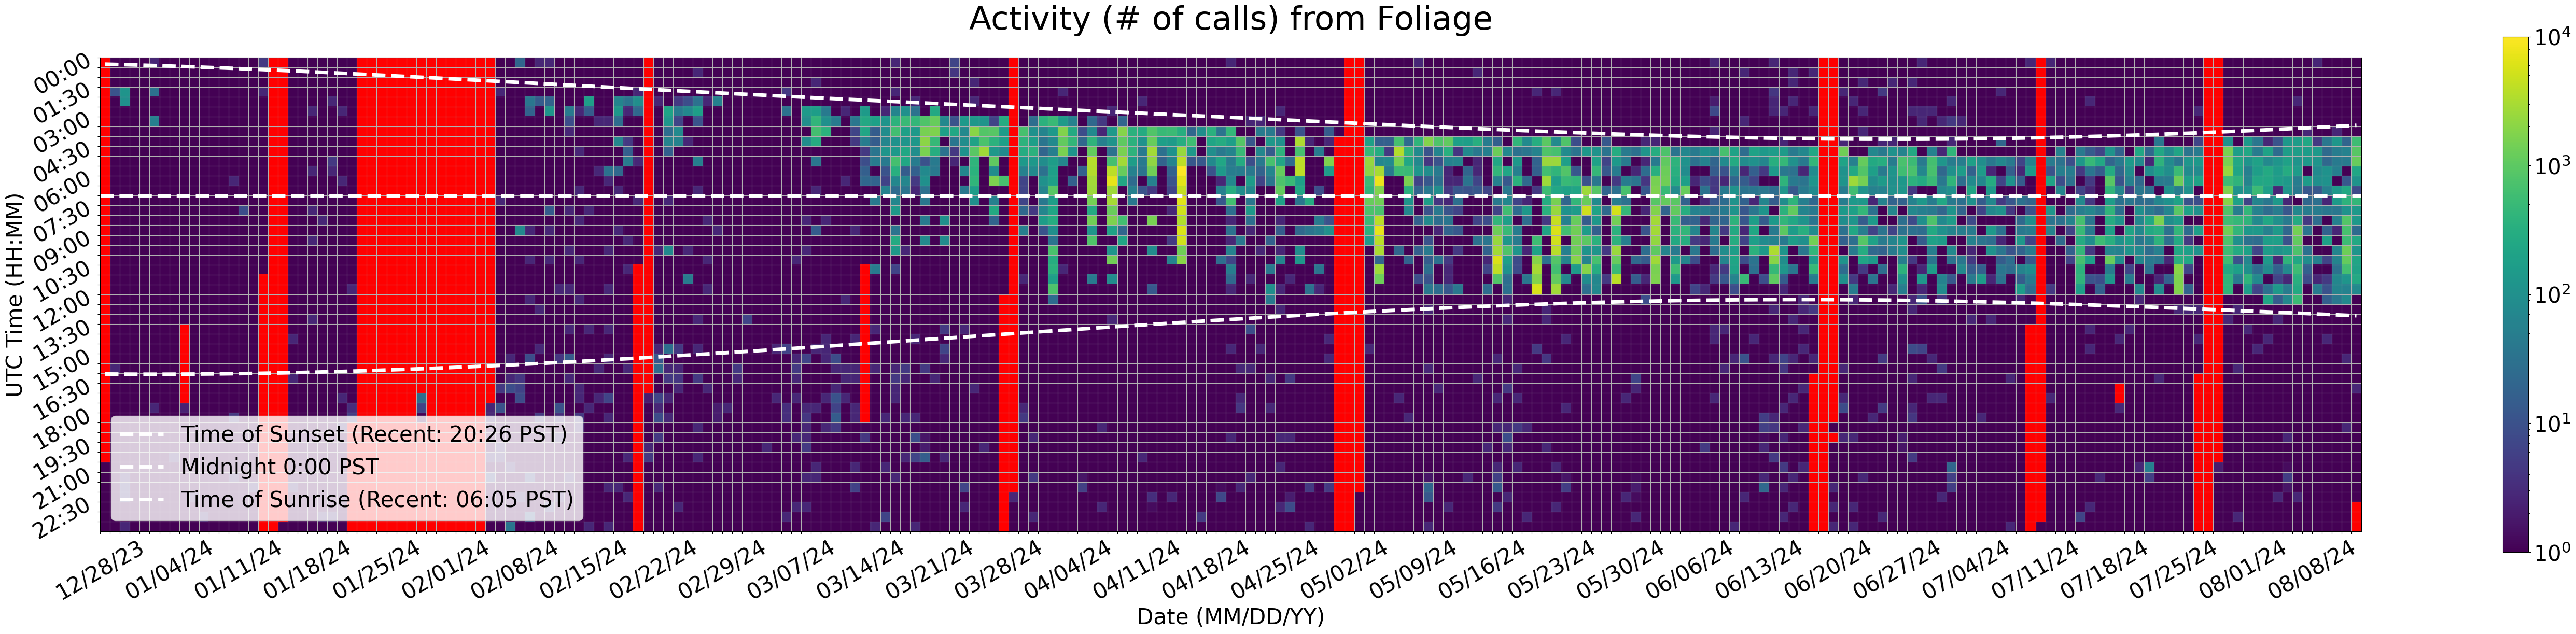

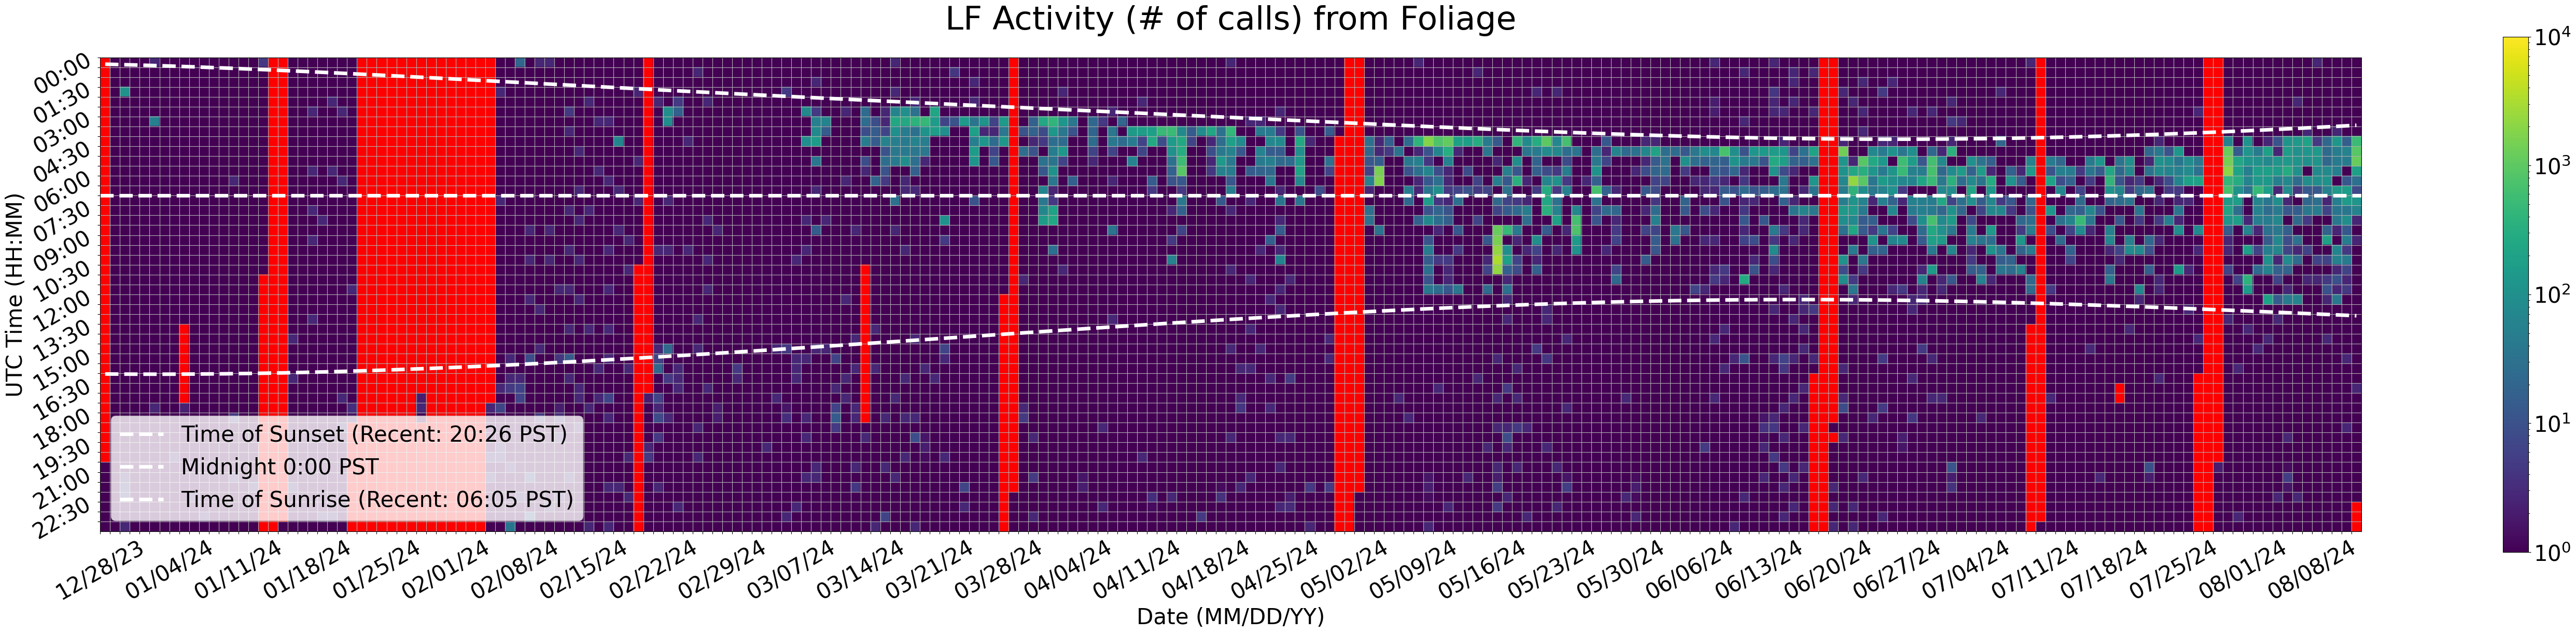

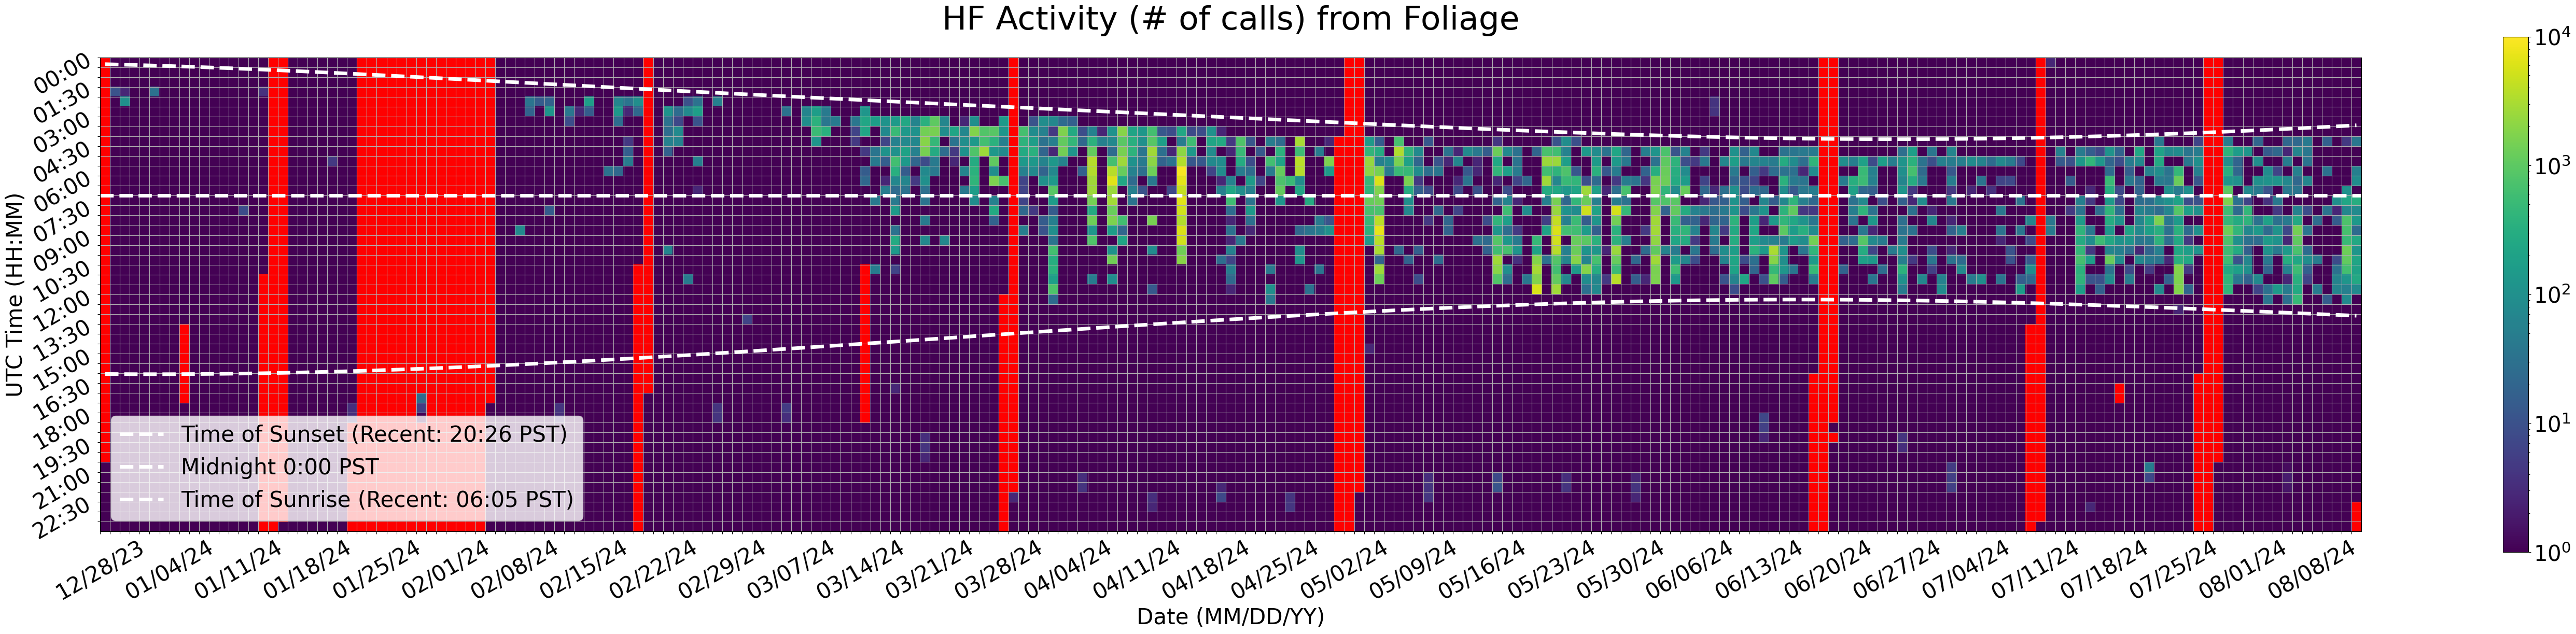

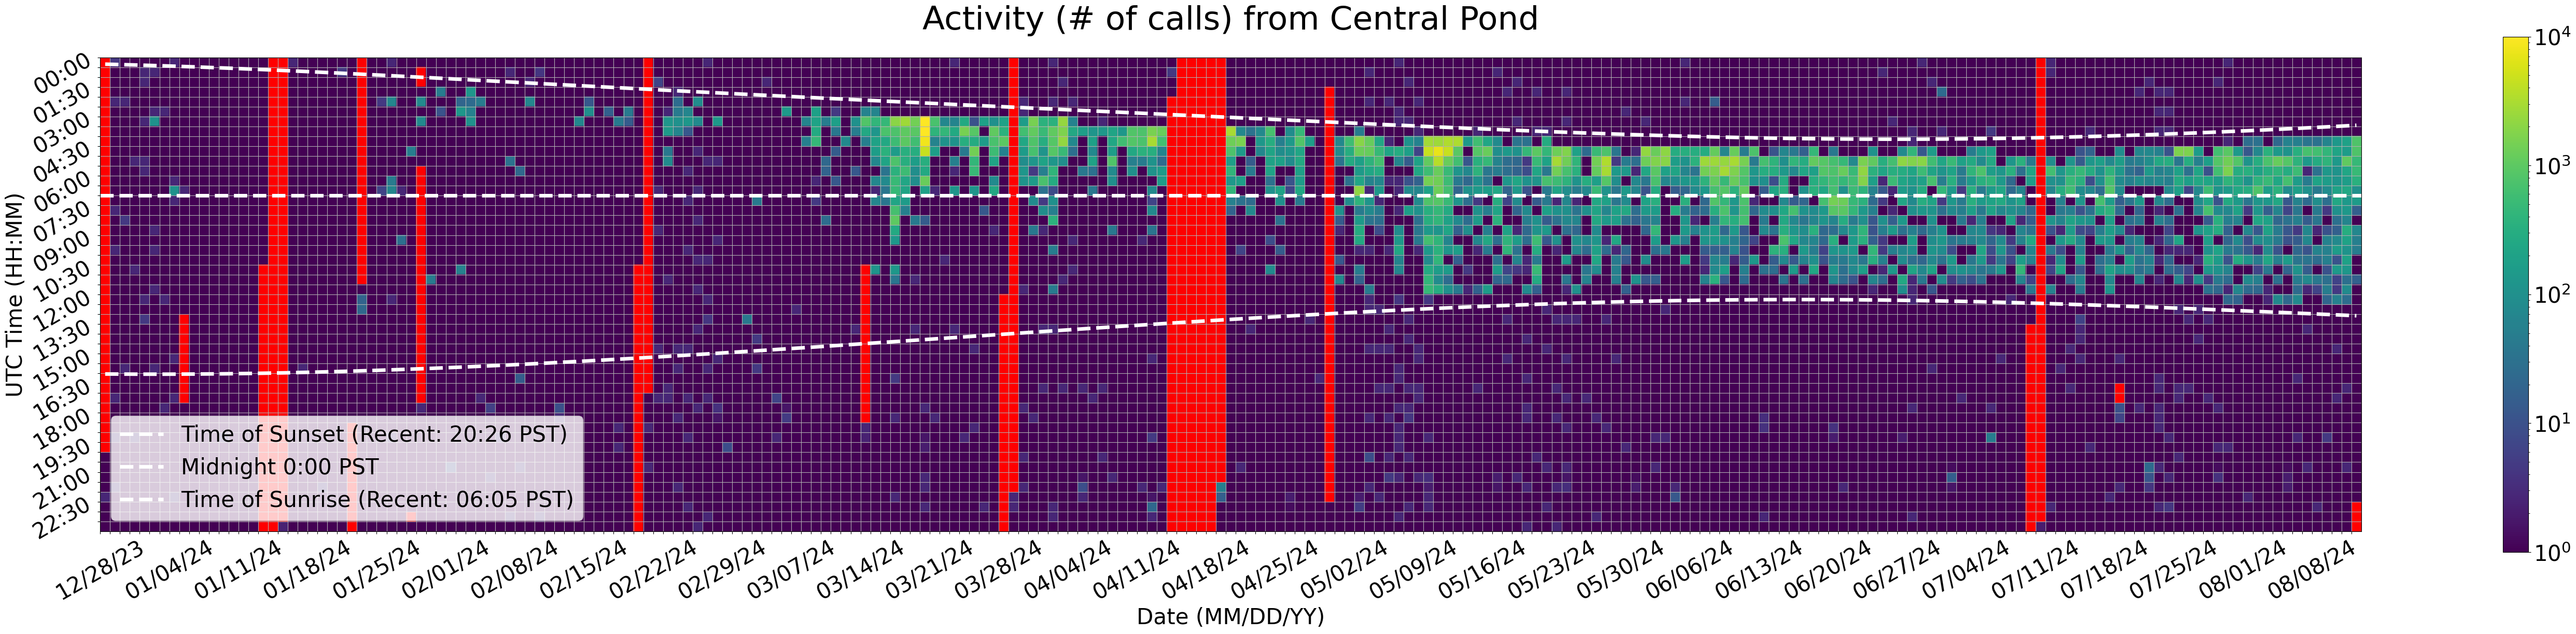

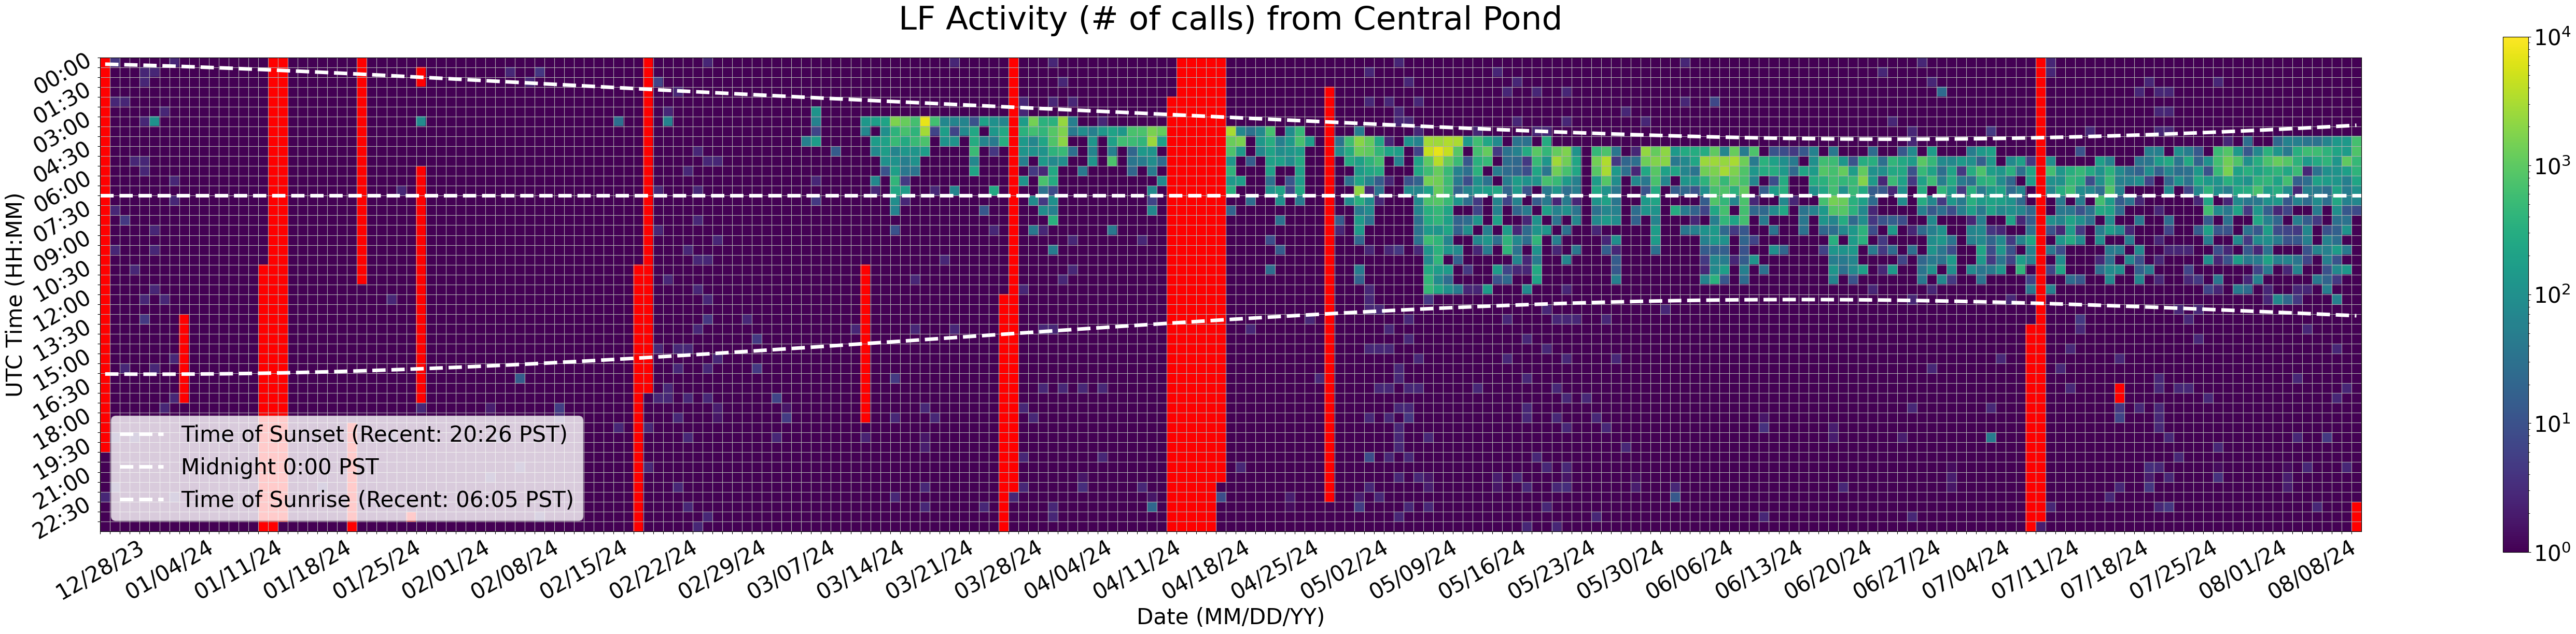

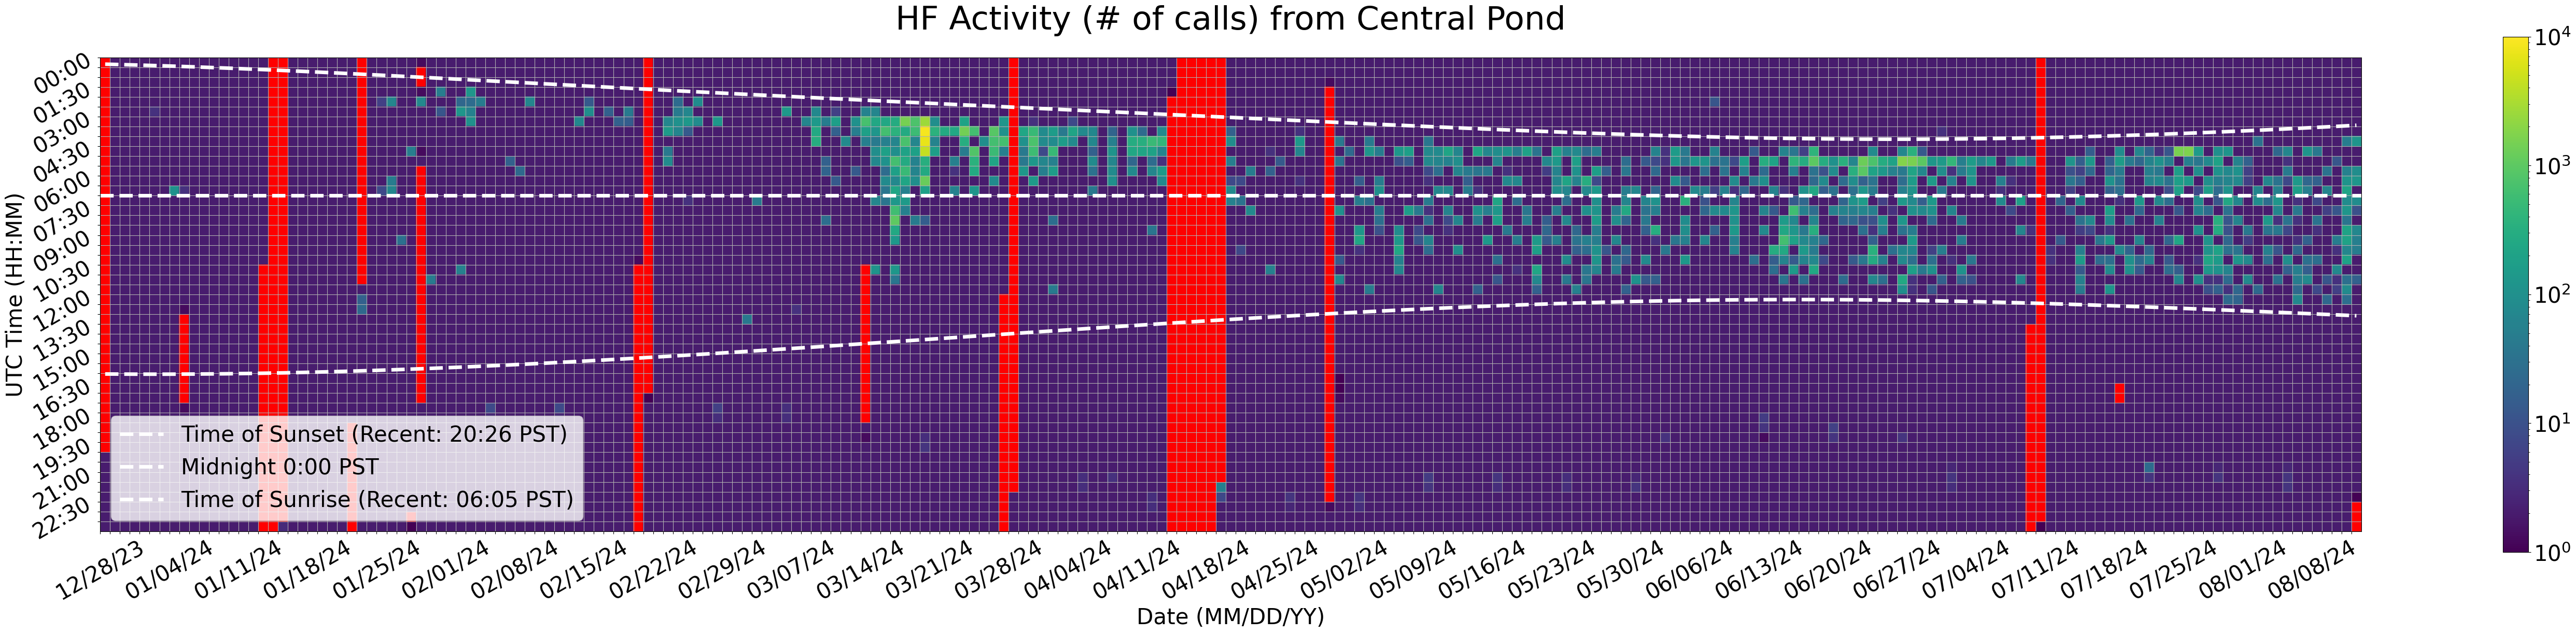

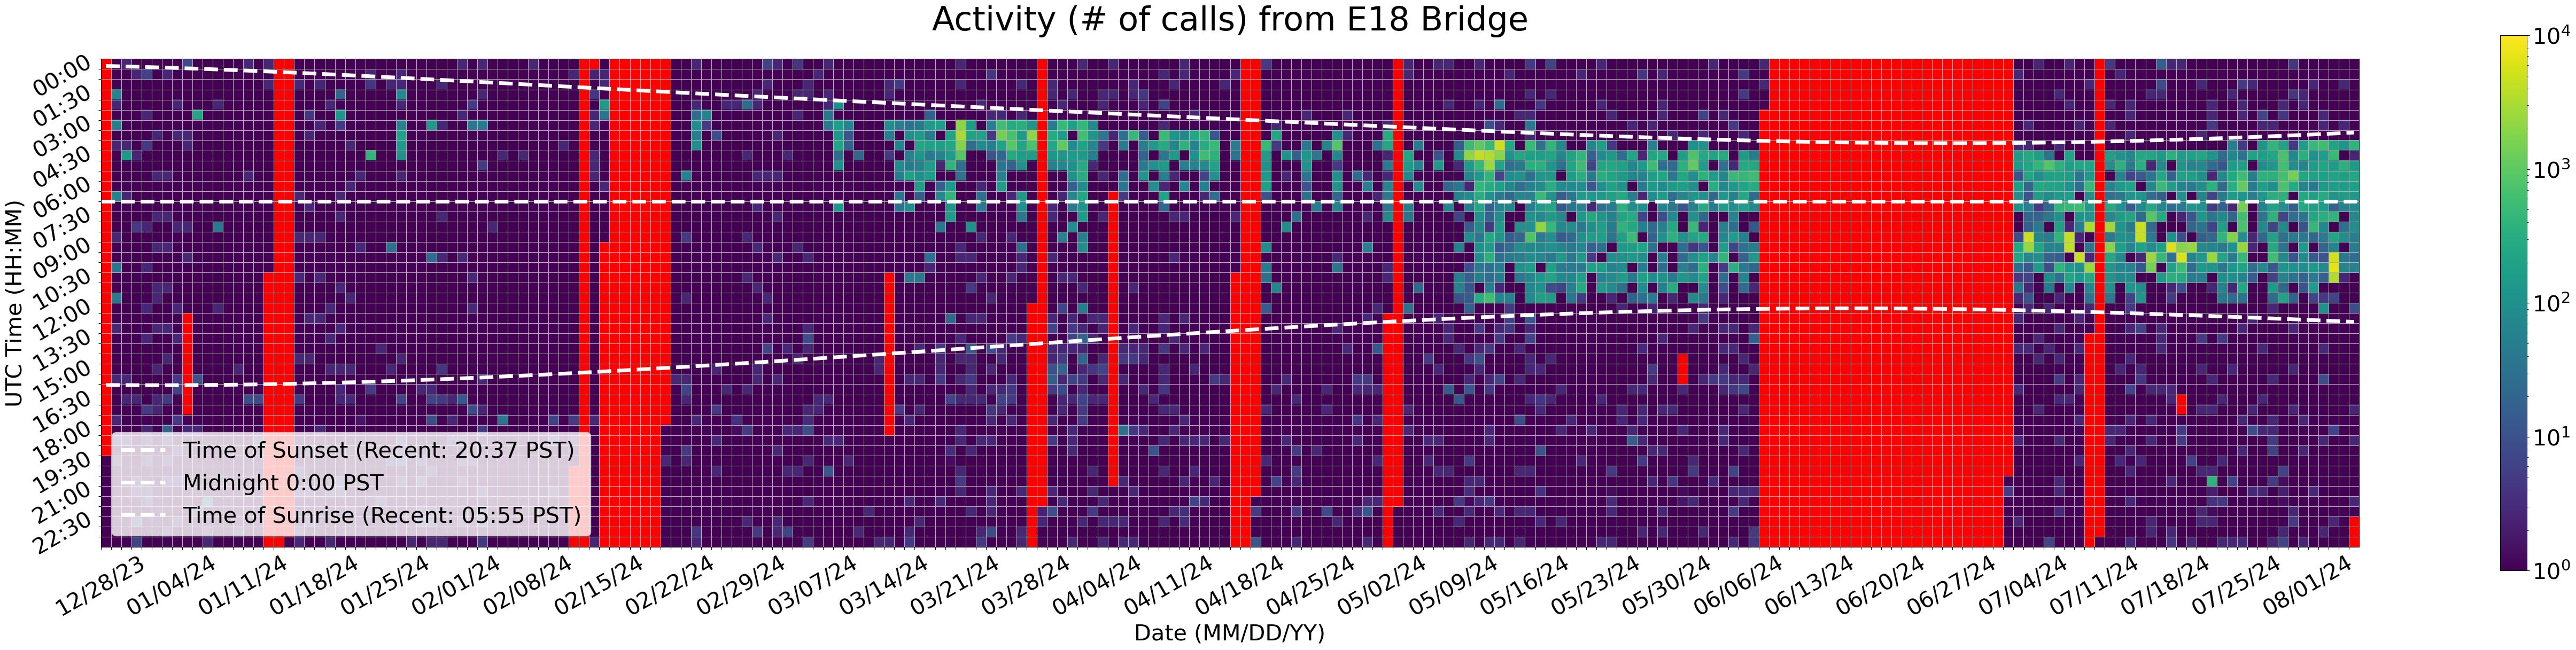

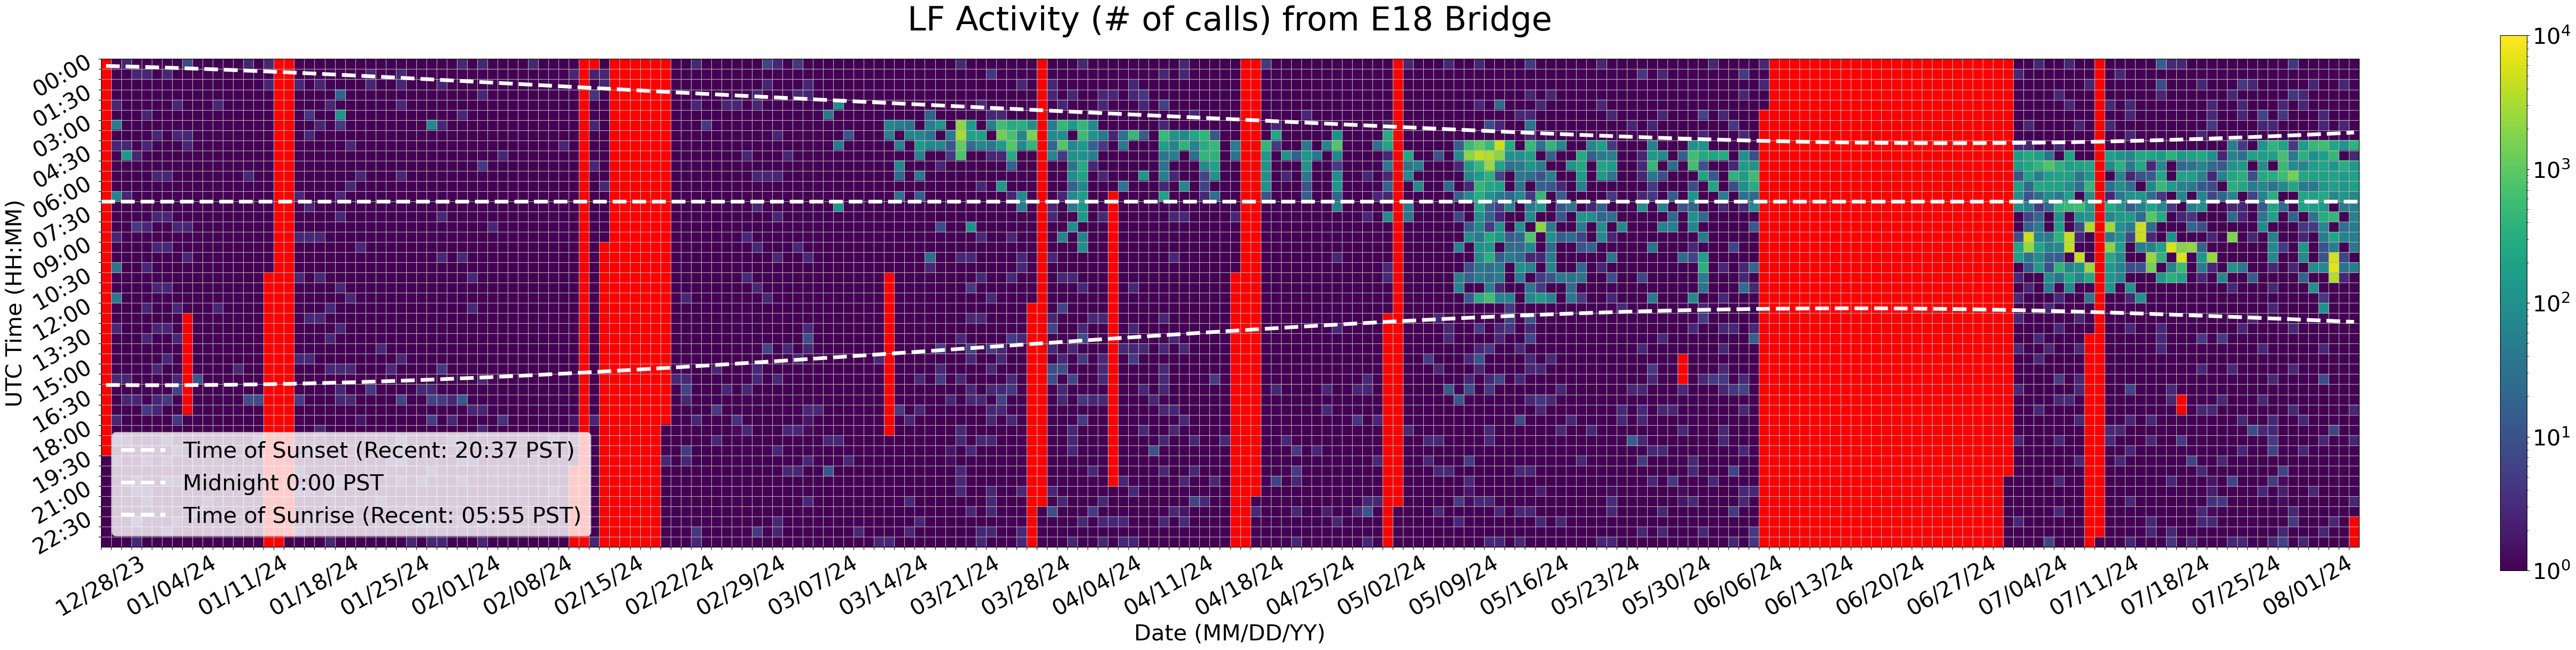

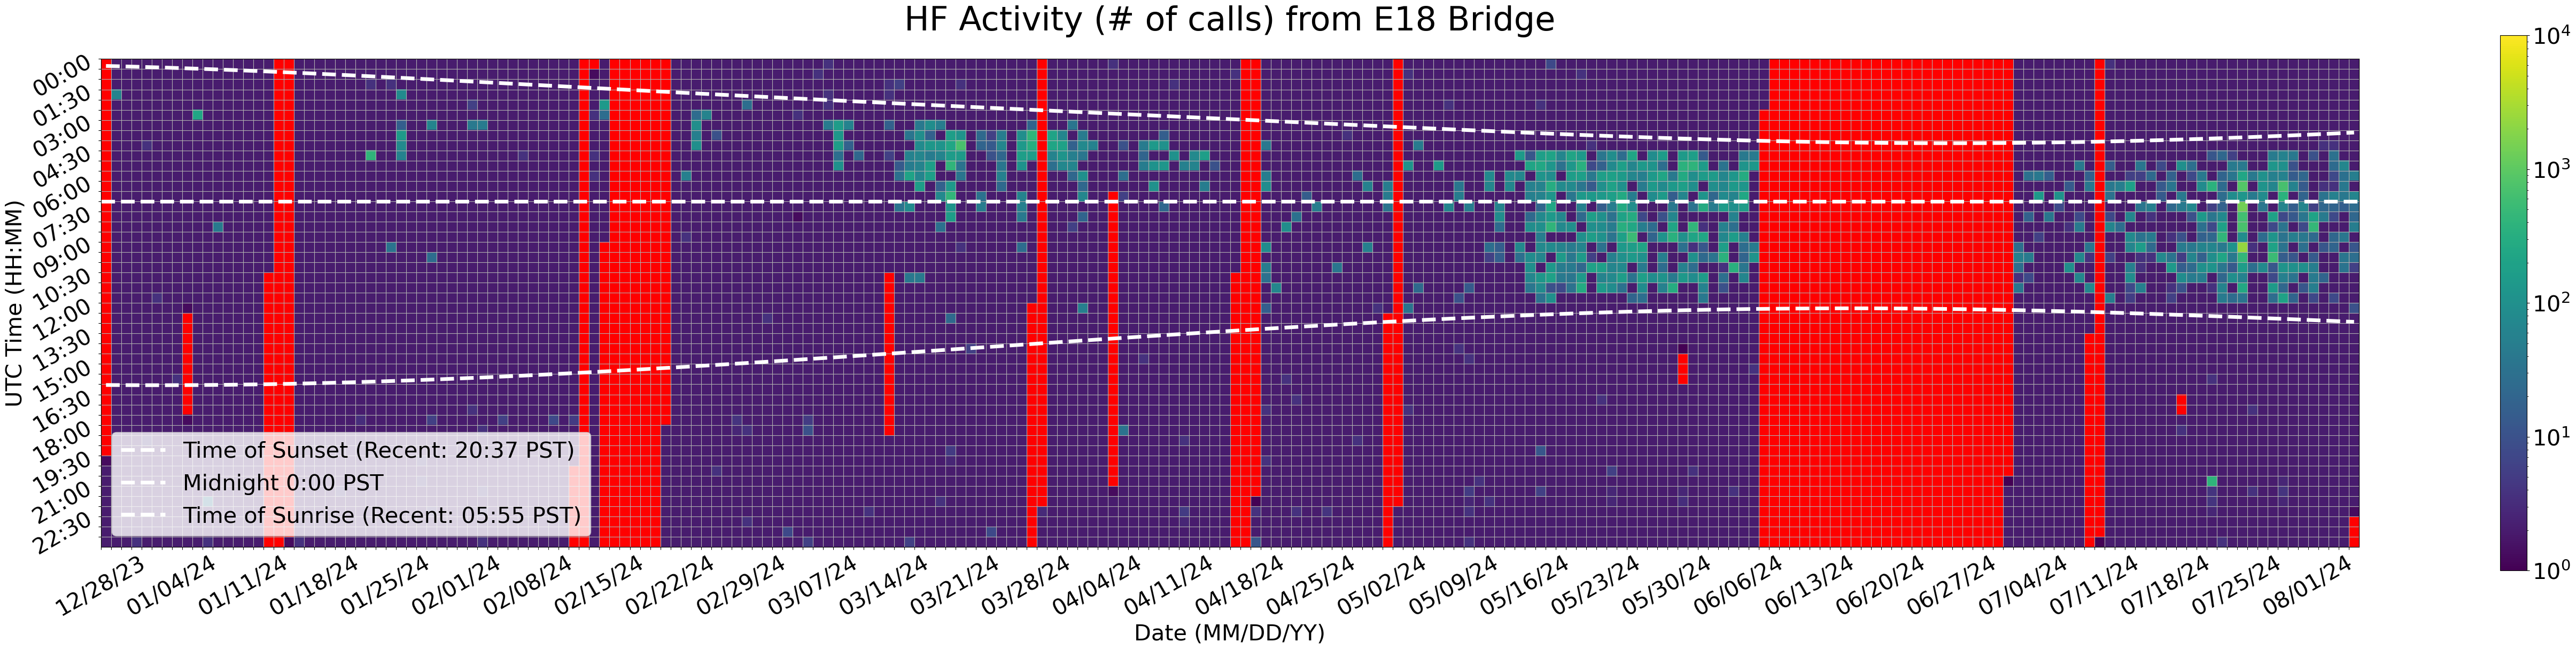

In [6]:
for site in ["Telephone Field", 'Foliage', 'Central Pond', 'E18 Bridge', 'Carp Pond']:
    for group in ['','LF','HF']:
        cfg = dict()
        cfg["site"] = site
        cfg["recording_start"] = '00:00'
        cfg["recording_end"] = '23:59'
        cfg['resample_tag'] = "30T"
        cfg['show_PST'] = False
        cfg['selection_of_dates'] = 'recover-2024*'


        activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, group, save=True)
        batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, group, save=True)